In [1]:
from tensorflow.keras import layers, models, backend, utils, metrics, preprocessing
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from wand.image import Image
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from sklearn import metrics as skmetrics
import numpy as np
import seaborn as sns
import os
import pandas as pd
import glob
import errno
import scipy
from scipy import ndimage
import imageio


In [2]:
DIR_PREFIX  = '/kaggle/input/evendata/input/real_vs_fake/real-vs-fake/'

def load_dataset(path):
    dataset = {"image_path":[],"img_status":[],"where":[]}
    for status in os.listdir(path):
        for image in glob.glob(path+"/"+status+"/"+"*.jpg"):
            dataset["image_path"].append(image)
            dataset["img_status"].append(status)
            dataset["where"].append("train")
    dataset = pd.DataFrame(dataset)
    dataset.value_counts("img_status")
    real = dataset.value_counts("img_status")[1]
    fake = dataset.value_counts("img_status")[0]

    print(f"Real: {real},\nFake: {fake}\n")
    sns.countplot(dataset["img_status"])
    plt.show()
    return dataset

def view_dataset(dataset):
    plt.figure(figsize = (14,10))
    for i in range(9):
        random = np.random.randint(1,len(dataset))
        plt.subplot(3,3,i+1)
        plt.imshow(plt.imread(dataset.loc[random,"image_path"]))
        plt.title(dataset.loc[random, "img_status"], size = 10) 
        plt.xticks([])
        plt.yticks([])

    plt.show()
    
def predict(img_path):
    input_arr = []
    count = 0
    image = preprocessing.image.load_img(
        img_path, grayscale=False, color_mode="rgb", target_size=(224, 224, 3)
    )
    i = preprocessing.image.img_to_array(image)
    input_arr = np.array([i])
    predictions = model.predict(input_arr)
    return predictions[0]

def predict_dataset(dataset):
    plt.figure(figsize = (14,10))
    for i in range(9):
        random = np.random.randint(1,len(dataset))
        plt.subplot(3,3,i+1)
        plt.imshow(plt.imread(dataset.loc[random,"image_path"]))
        predicted = predict(dataset.loc[random,"image_path"]);
        plt.title(f"{dataset.loc[random, 'img_status']} accuracy: {predicted}", size = 10) 
        plt.xticks([])
        plt.yticks([])
    

def convert_to_edge(dir_name='train'):
    try:
        os.mkdir('./output/'+dir_name)
        os.mkdir('./output/'+dir_name+'/fake')
        os.mkdir('./output/'+dir_name+'/real')
    except OSError as exc:
        if exc.errno != errno.EEXIST:
            raise
        pass
    i = 0
    print('data processed for '+dir_name)
    for filename in os.listdir(DIR_PREFIX+dir_name):
        f = os.path.join(DIR_PREFIX+dir_name, filename)
        # checking if it is a file
        if os.path.isdir(f):
            convert_to_edge(dir_name+'/'+filename)
        else:
            i = i+1
            im = imageio.imread(f)
            im = im.astype('int32')
            dx = ndimage.prewitt(im, 0)  # horizontal derivative
            dy = ndimage.prewitt(im, 1)  # vertical derivative
            mag = np.hypot(dx, dy)  # magnitude
            mag *= 255.0 / np.max(mag)  # normalize (Q&D)
            imageio.imsave(f.replace(DIR_PREFIX,'./output/'), mag)
            print(i, end='\r')
            
try:
    os.mkdir('./output')
except OSError as exc:
    pass

Real: 4000,
Fake: 4000



/opt/conda/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


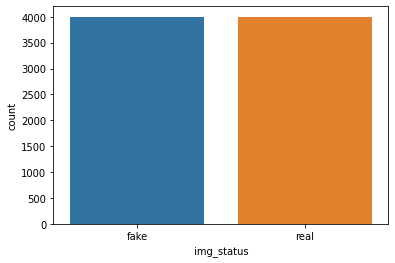

In [3]:
path  = '/kaggle/input/evendata/input/real_vs_fake/real-vs-fake/train'
train_dataset = load_dataset(path)

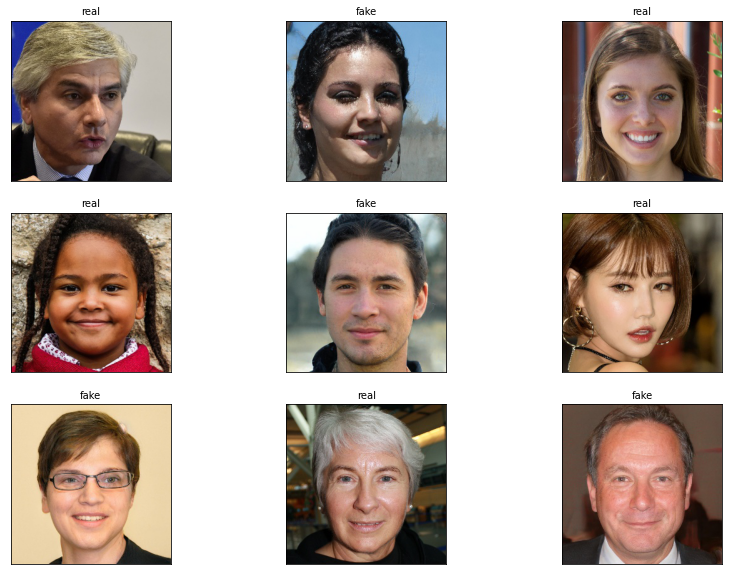

In [4]:
view_dataset(train_dataset)

In [5]:
convert_to_edge('valid')
convert_to_edge('train')

data processed for valid
data processed for valid/fake
data processed for valid/real
data processed for train
data processed for train/fake
data processed for train/real


Real: 4000,
Fake: 4000



/opt/conda/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


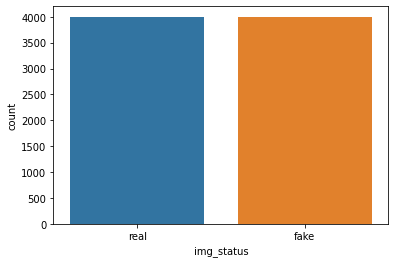

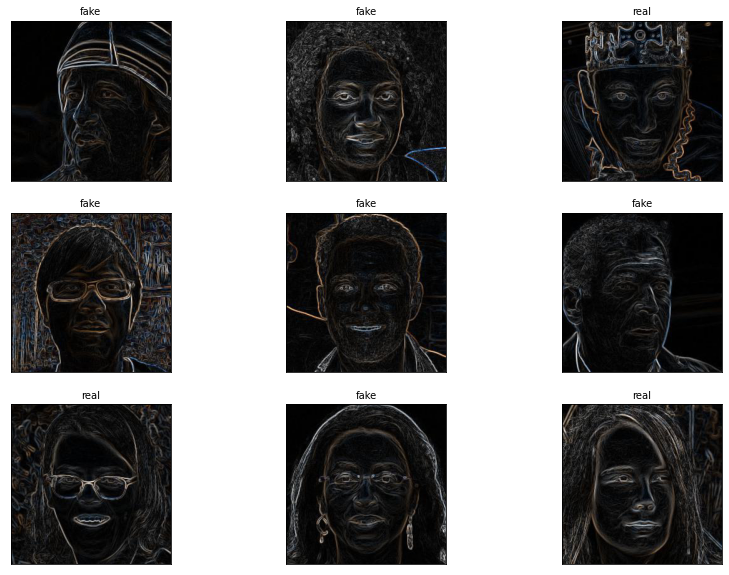

In [6]:
path  = './output/train'
train_dataset_preprocessed = load_dataset(path)
view_dataset(train_dataset_preprocessed)

In [7]:
base_path = './output/'
train_flow = preprocessing.image_dataset_from_directory(
    base_path + 'train/',
    image_size=(224, 224),
    batch_size=64,
    labels='inferred',
    label_mode='binary'
)
test_flow = preprocessing.image_dataset_from_directory(
    '/kaggle/input/evendata/input/real_vs_fake/real-vs-fake/test',
    image_size=(224, 224),
    batch_size=64,
    labels='inferred',
    label_mode='binary'
)
valid_flow = preprocessing.image_dataset_from_directory(
    base_path + 'valid/',
    image_size=(224, 224),
    batch_size=64,
    labels='inferred',
    label_mode='binary'
)
train_flow.class_names

Found 8000 files belonging to 2 classes.


2022-06-18 07:17:58.257976: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-06-18 07:17:58.381212: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-06-18 07:17:58.382250: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-06-18 07:17:58.385131: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags

Found 3587 files belonging to 2 classes.
Found 2000 files belonging to 2 classes.


['fake', 'real']

In [8]:
model = models.Sequential()

model.add(
    layers.Conv2D(32, (3, 3),activation='relu', input_shape=(224, 224, 3))
)

model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(128, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(256, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(256, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(512, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Flatten())
model.add(layers.Dense(512, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))
# output node 1 means prediction in 0 -- 1 and decimals
# output node 2 means predication of 0 or 1 no decimals
model.summary()

model.compile(
    optimizer = 'adam', 
    loss = 'binary_crossentropy', 
    metrics = [
        'accuracy'
    ]
)

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 222, 222, 32)      896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 111, 111, 32)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 109, 109, 64)      18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 54, 54, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 52, 52, 128)       73856     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 26, 26, 128)       0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 24, 24, 256)       2

In [9]:
train_steps = 4000//64
valid_steps = 4000//64

hist = model.fit(
    train_flow,
    epochs=10,
    validation_data=valid_flow,
    batch_size=64
)

Epoch 1/10


2022-06-18 07:18:09.698593: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)
2022-06-18 07:18:11.532041: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


125/125 [==============================] - 26s 133ms/step - loss: 1.1574 - accuracy: 0.5794 - val_loss: 0.6296 - val_accuracy: 0.6530
Epoch 2/10
125/125 [==============================] - 17s 131ms/step - loss: 0.5829 - accuracy: 0.6929 - val_loss: 0.5483 - val_accuracy: 0.7285
Epoch 3/10
125/125 [==============================] - 17s 132ms/step - loss: 0.4950 - accuracy: 0.7629 - val_loss: 0.4982 - val_accuracy: 0.7605
Epoch 4/10
125/125 [==============================] - 18s 130ms/step - loss: 0.4080 - accuracy: 0.8149 - val_loss: 0.4779 - val_accuracy: 0.7815
Epoch 5/10
125/125 [==============================] - 17s 133ms/step - loss: 0.3259 - accuracy: 0.8622 - val_loss: 0.4957 - val_accuracy: 0.7845
Epoch 6/10
125/125 [==============================] - 16s 127ms/step - loss: 0.2682 - accuracy: 0.8852 - val_loss: 0.4718 - val_accuracy: 0.8190
Epoch 7/10
125/125 [==============================] - 18s 140ms/step - loss: 0.2128 - accuracy: 0.9143 - val_loss: 0.6193 - val_accuracy: 0.7

In [10]:
y_pred = model.predict(test_flow)
y_pred

array([[0.8276802 ],
       [0.92931277],
       [0.70177805],
       ...,
       [0.9206039 ],
       [0.77359897],
       [0.940745  ]], dtype=float32)

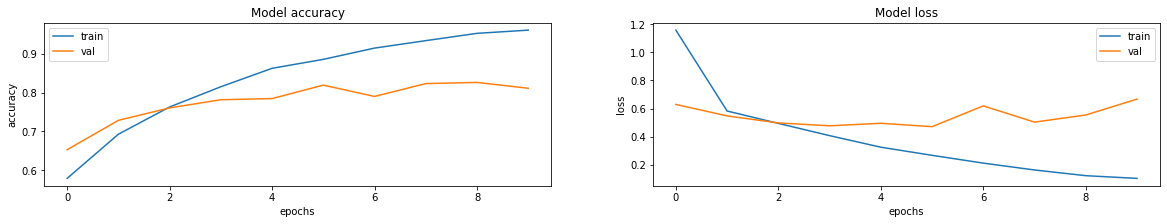

In [11]:
fig, ax = plt.subplots(1, 2, figsize=(20, 3))
ax = ax.ravel()

for i, met in enumerate([ "accuracy", "loss"]):
    ax[i].plot(hist.history[met])
    ax[i].plot(hist.history["val_" + met])
    ax[i].set_title("Model {}".format(met))
    ax[i].set_xlabel("epochs")
    ax[i].set_ylabel(met)
    ax[i].legend(["train", "val"])

In [12]:
# path  = '/kaggle/input/evendata/input/real_vs_fake/real-vs-fake/test'
# test_dataset = load_dataset(path)
# predict_dataset(test_dataset)